# Data Normalization

**Why Data needs to be in the same scale?**

$$ \hat{y} = \sigma(x^T w) $$
$$ w \leftarrow w - \mu \, dL
$$

**Z-normalization and min-max scaling**

$$ z_i = \frac{x_i -  \bar{x}} {\sigma x} $$

Z-transform shifts and stretches, but doesn't change shape.

**Min-max scaling: the formula**

Scale to a range of 0 to 1.

$$  x = \frac{x - min x}{\text{max} x - min x} $$

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy import stats

Text(0.5, 1.0, 'Post Z-Score Iris')

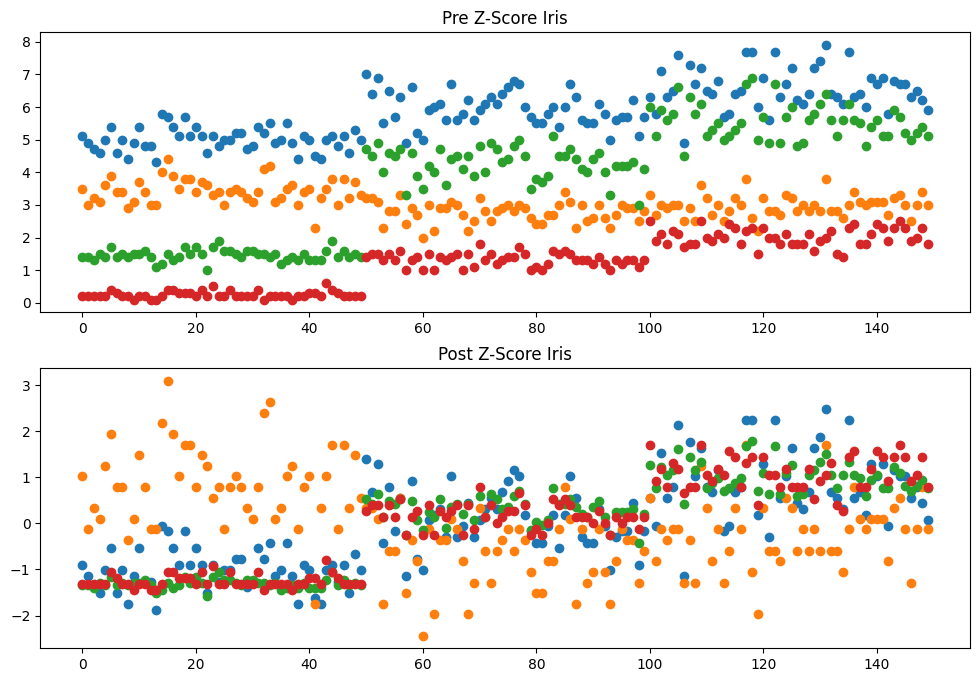

In [2]:
data, labels = datasets.load_iris()['data'], datasets.load_iris()['target']

fig, ax = plt.subplots(2, 1, figsize = (12, 8))
ax[0].plot(data, 'o')
ax[0].set_title('Pre Z-Score Iris')

data_z = stats.zscore(data)

ax[1].plot(data_z, 'o')
ax[1].set_title('Post Z-Score Iris')

# Batch Normalization

## Experiment 1

$$ y = \sigma(\overset{\sim}{x}^T w), \text{where } \overset{\sim}{x} \text{ is nomralized input} $$

$$ \overset{\sim}{x} = \gamma x + \beta $$

BatchNorm goes before the activation function.

Batch normalization should only be applied during training. During validation/test should be switched off, because batch size could differ (e.g., N=1). Instead, the model applies the learned parameters from training.

Batch norm should be actually called layer norm, since it normalizes all values coming out of a layer, across all same layer values.

In [3]:
import pandas as pd

import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import time

### Data

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
                 sep = ';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### Raw

/tmp/ipython-input-893927195.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


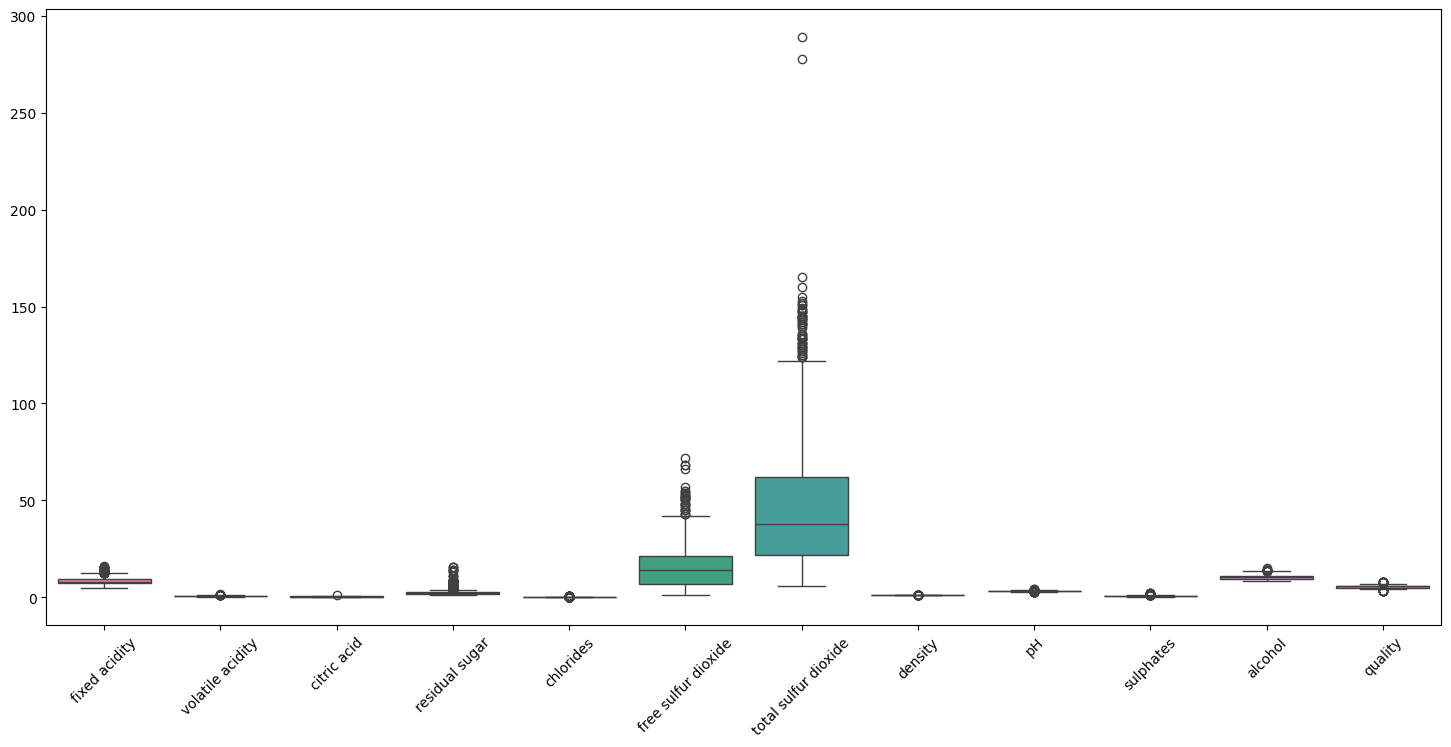

In [6]:
fig, ax = plt.subplots(1, figsize = (18, 8))

ax = sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

#### No Outliers

/tmp/ipython-input-2213969766.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


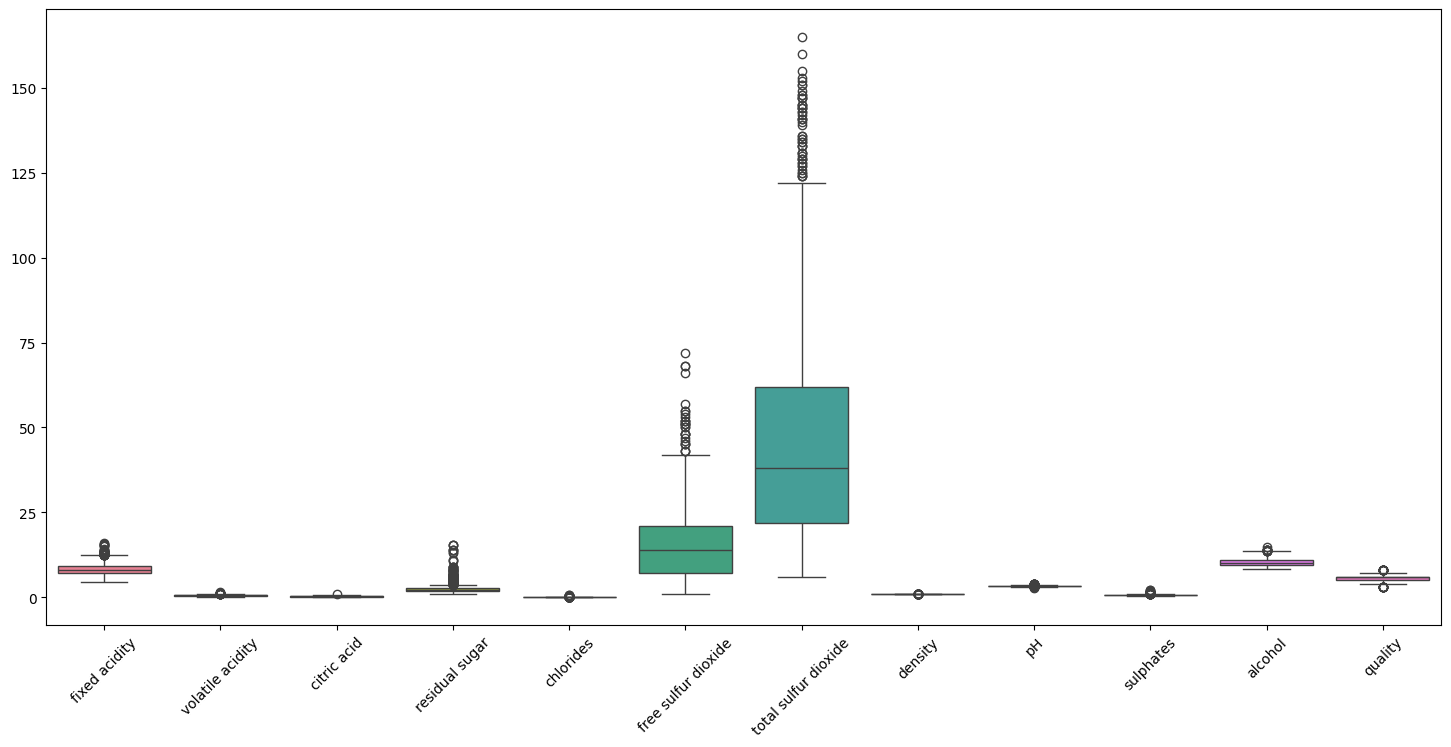

In [7]:
df = df.loc[df['total sulfur dioxide'] < 200]

fig, ax = plt.subplots(1, figsize = (18, 8))

ax = sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

#### Z-scored

/tmp/ipython-input-314863485.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


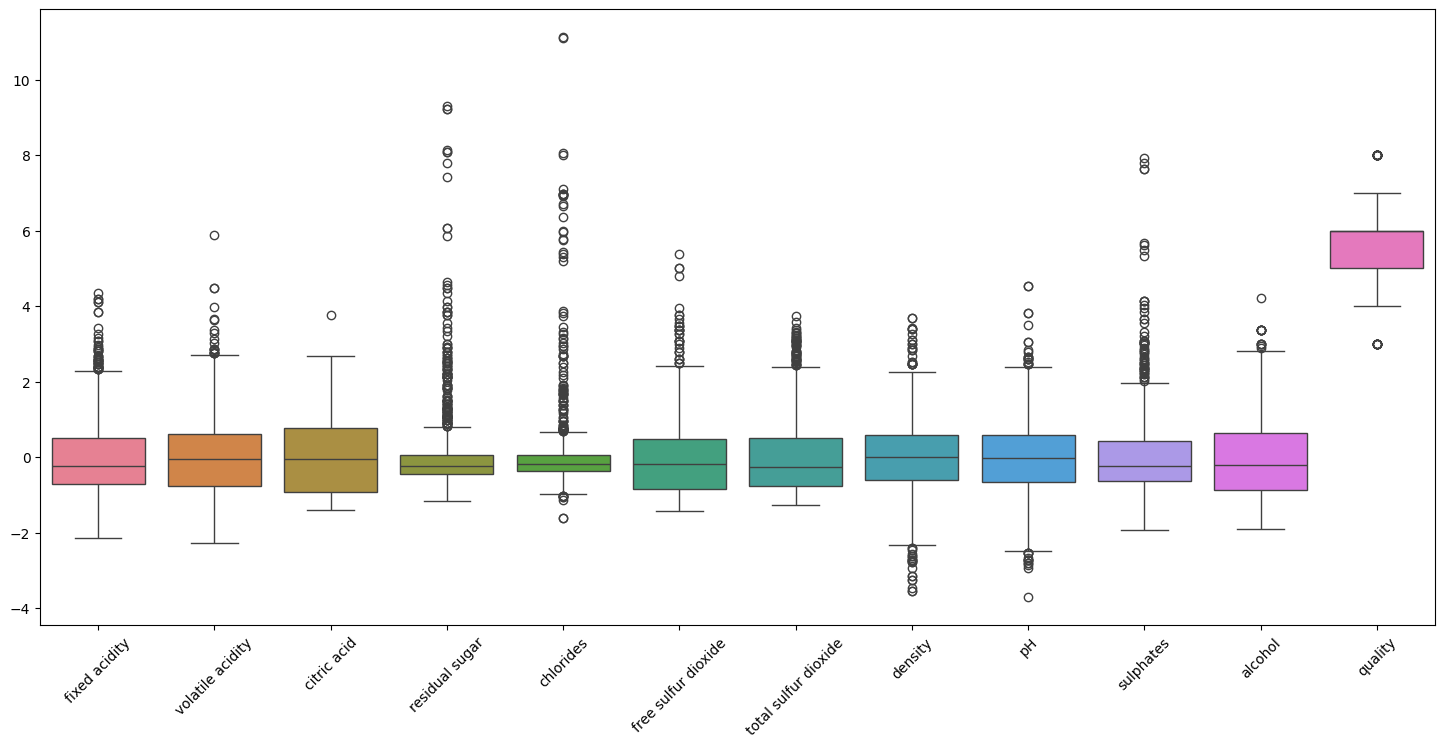

In [8]:
cols_2_zscore = df.keys().drop('quality')
df[cols_2_zscore] = df[cols_2_zscore].apply(stats.zscore)

fig, ax = plt.subplots(1, figsize = (18, 8))

ax = sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

#### Binarized

In [9]:
df['quality'].value_counts().keys()

Index([5, 6, 7, 4, 8, 3], dtype='int64', name='quality')

<BarContainer object of 6 artists>

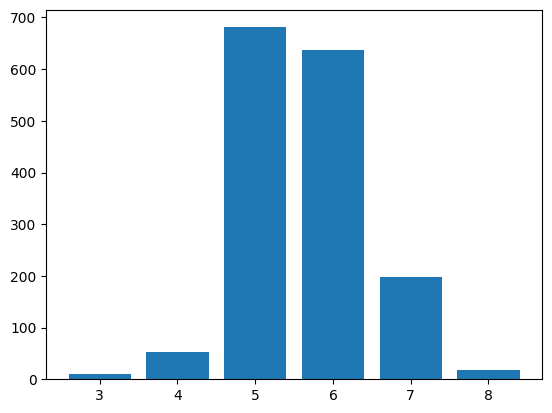

In [10]:
plt.bar(df['quality'].value_counts().keys(), list(df['quality'].value_counts()))

/tmp/ipython-input-2316742738.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['bool_quality'][df['quality'] > 5] = 1
/tmp/ipython-input-2316742738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

<BarContainer object of 2 artists>

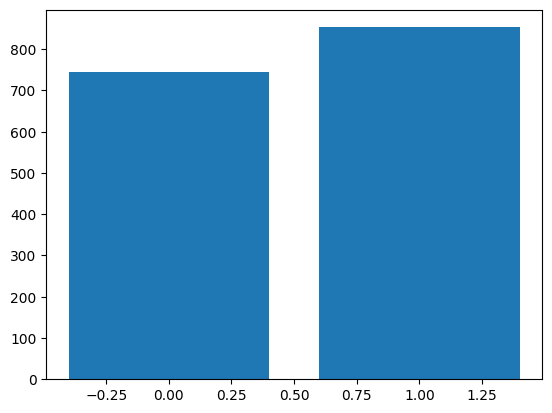

In [11]:
df['bool_quality'] = 0
df['bool_quality'][df['quality'] > 5] = 1
plt.bar(df['bool_quality'].value_counts().keys(), list(df['bool_quality'].value_counts()))

### Split

In [12]:
data = torch.tensor(df[cols_2_zscore].values).float()
labels = torch.tensor(df['bool_quality'].values).float()
labels = labels[:, None]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = .8)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = X_train.shape[0])

### Model Arch

In [14]:
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    # input
    self.input = nn.Linear(11, 16)

    # hidden
    self.bnorm1 = nn.BatchNorm1d(16) # number of units into this layer
    self.fc1 = nn.Linear(16, 32)
    self.bnorm2 = nn.BatchNorm1d(32)
    self.fc2 = nn.Linear(32, 20)

    # output
    self.output = nn.Linear(20, 1)

  # forward pass
  def forward(self, x, batch_norm):

    x = self.input(x)
    x = F.relu(x)

    if batch_norm:
      # hidden layer 1
      x= self.bnorm1(x) # batchnorm
      x = self.fc1(x)   # weighted combination
      x = F.relu(x)     # activation function

      # hidden layer 2
      x = self.bnorm2(x) # batchnorm
      x = self.fc2(x)# weighted combination
      x = F.relu(x)

    else:
      x = self.fc1(x)
      x = F.relu(x)

      x = self.fc2(x)
      x = F.relu(x)

    x = self.output(x)

    return x

### Model Setup

In [15]:
def ModelSetup():
  ann = ModelArch()
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-3)

  return ann, loss_fn, optimizer

In [16]:
ann, loss_fn, optimizer = ModelSetup()
ann, loss_fn, optimizer

(ModelArch(
   (input): Linear(in_features=11, out_features=16, bias=True)
   (bnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc1): Linear(in_features=16, out_features=32, bias=True)
   (bnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc2): Linear(in_features=32, out_features=20, bias=True)
   (output): Linear(in_features=20, out_features=1, bias=True)
 ),
 BCEWithLogitsLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

### Model Train

In [17]:
def ModelTrain(epochs, batch_norm = True):
  ann, loss_fn, optimizer = ModelSetup()

  losses = torch.zeros(epochs)

  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_accs = torch.zeros(len(train_dataloader))
    batch_losses = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):

      batch_y_hat = ann(X_train, batch_norm)

      loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = loss

      acc = 100 * torch.mean(
          ( (batch_y_hat > 0) == y_train ).float()
      )
      batch_accs[batch] = acc

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    # test accuracy
    ann.eval()
    X_test, y_test = next(iter(test_dataloader))
    with torch.no_grad():
      test_y_hat = ann(X_test, batch_norm)
    test_acc = 100 * torch.mean(
        ( (test_y_hat > 0) == y_test ).float()
    )
    test_accs[epoch] = test_acc

    if epoch % 10 == 0:
      print(f'Epoch {epoch} | Loss: {torch.mean(batch_losses):2f} | Train Acc: {torch.mean(batch_accs):2f} | Test Acc: {test_acc:2f}')

  return train_accs, test_accs, losses

In [18]:
train_accs, test_accs, losses = ModelTrain(epochs = 500, batch_norm = True)

Epoch 0 | Loss: 0.657650 | Train Acc: 68.092102 | Test Acc: 65.625000
Epoch 10 | Loss: 0.647519 | Train Acc: 69.983551 | Test Acc: 65.000000
Epoch 20 | Loss: 0.631785 | Train Acc: 71.710526 | Test Acc: 66.562500
Epoch 30 | Loss: 0.620907 | Train Acc: 71.957237 | Test Acc: 65.937500
Epoch 40 | Loss: 0.610051 | Train Acc: 71.381577 | Test Acc: 66.562500
Epoch 50 | Loss: 0.599616 | Train Acc: 71.957237 | Test Acc: 66.875000
Epoch 60 | Loss: 0.590769 | Train Acc: 72.450661 | Test Acc: 67.500000
Epoch 70 | Loss: 0.583558 | Train Acc: 72.450661 | Test Acc: 67.187500
Epoch 80 | Loss: 0.573063 | Train Acc: 72.779602 | Test Acc: 67.812500
Epoch 90 | Loss: 0.563971 | Train Acc: 73.766449 | Test Acc: 68.125000
Epoch 100 | Loss: 0.555164 | Train Acc: 74.753288 | Test Acc: 69.062500
Epoch 110 | Loss: 0.548117 | Train Acc: 74.259865 | Test Acc: 68.125000
Epoch 120 | Loss: 0.546758 | Train Acc: 74.095398 | Test Acc: 67.812500
Epoch 130 | Loss: 0.536441 | Train Acc: 74.588814 | Test Acc: 68.437500
Epo

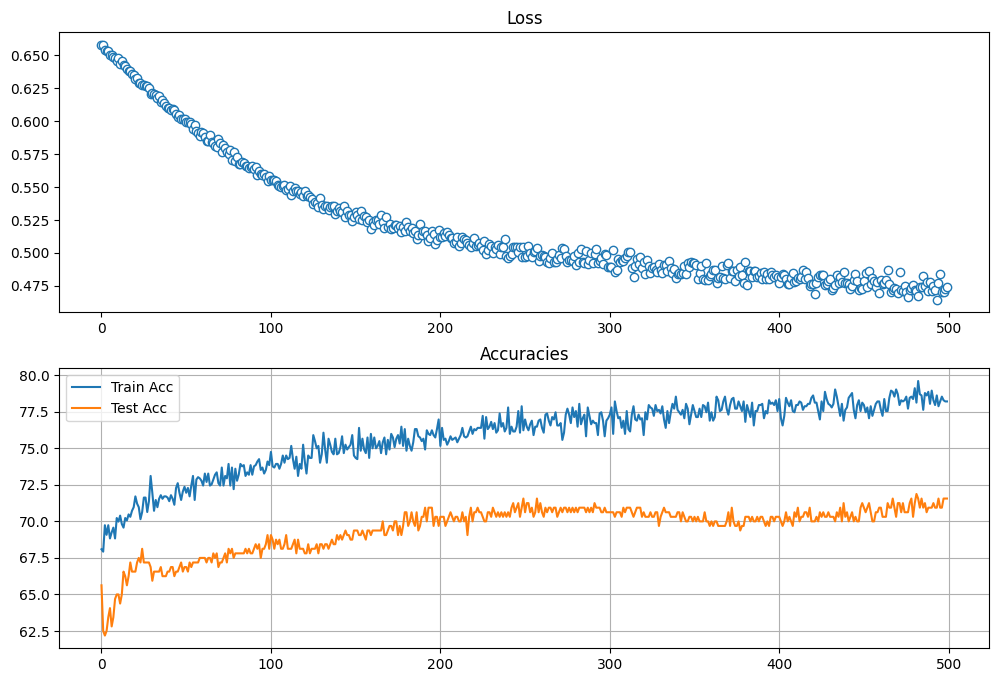

In [19]:
fig, ax = plt.subplots(2, 1, figsize = (12, 8))
ax[0].plot(losses.detach(), 'o', markerfacecolor = 'w')
ax[0].set_title('Loss')

ax[1].plot(train_accs, '-')
ax[1].plot(test_accs, '-')
ax[1].legend(['Train Acc', 'Test Acc'])
ax[1].set_title('Accuracies')
ax[1].grid()

plt.show()

### Batch Norm Experiment

In [20]:
bn_train_accs, bn_test_accs, bn_losses = ModelTrain(epochs = 1000, batch_norm = True)
nbn_train_accs, nbn_test_accs, nbn_losses = ModelTrain(epochs = 1000, batch_norm = False)

Epoch 0 | Loss: 0.753123 | Train Acc: 46.463818 | Test Acc: 45.625000
Epoch 10 | Loss: 0.727095 | Train Acc: 47.697369 | Test Acc: 46.250000
Epoch 20 | Loss: 0.710669 | Train Acc: 47.615131 | Test Acc: 47.500000
Epoch 30 | Loss: 0.697374 | Train Acc: 50.000000 | Test Acc: 50.937496
Epoch 40 | Loss: 0.684040 | Train Acc: 53.536182 | Test Acc: 54.062496
Epoch 50 | Loss: 0.672933 | Train Acc: 57.565788 | Test Acc: 56.875004
Epoch 60 | Loss: 0.661684 | Train Acc: 60.608551 | Test Acc: 60.312496
Epoch 70 | Loss: 0.653177 | Train Acc: 63.569080 | Test Acc: 64.062500
Epoch 80 | Loss: 0.640731 | Train Acc: 66.776314 | Test Acc: 65.625000
Epoch 90 | Loss: 0.632906 | Train Acc: 68.832237 | Test Acc: 65.312500
Epoch 100 | Loss: 0.624508 | Train Acc: 70.312500 | Test Acc: 66.250000
Epoch 110 | Loss: 0.612599 | Train Acc: 71.957237 | Test Acc: 65.937500
Epoch 120 | Loss: 0.603839 | Train Acc: 71.957237 | Test Acc: 67.187500
Epoch 130 | Loss: 0.595914 | Train Acc: 73.026314 | Test Acc: 67.812500
Epo

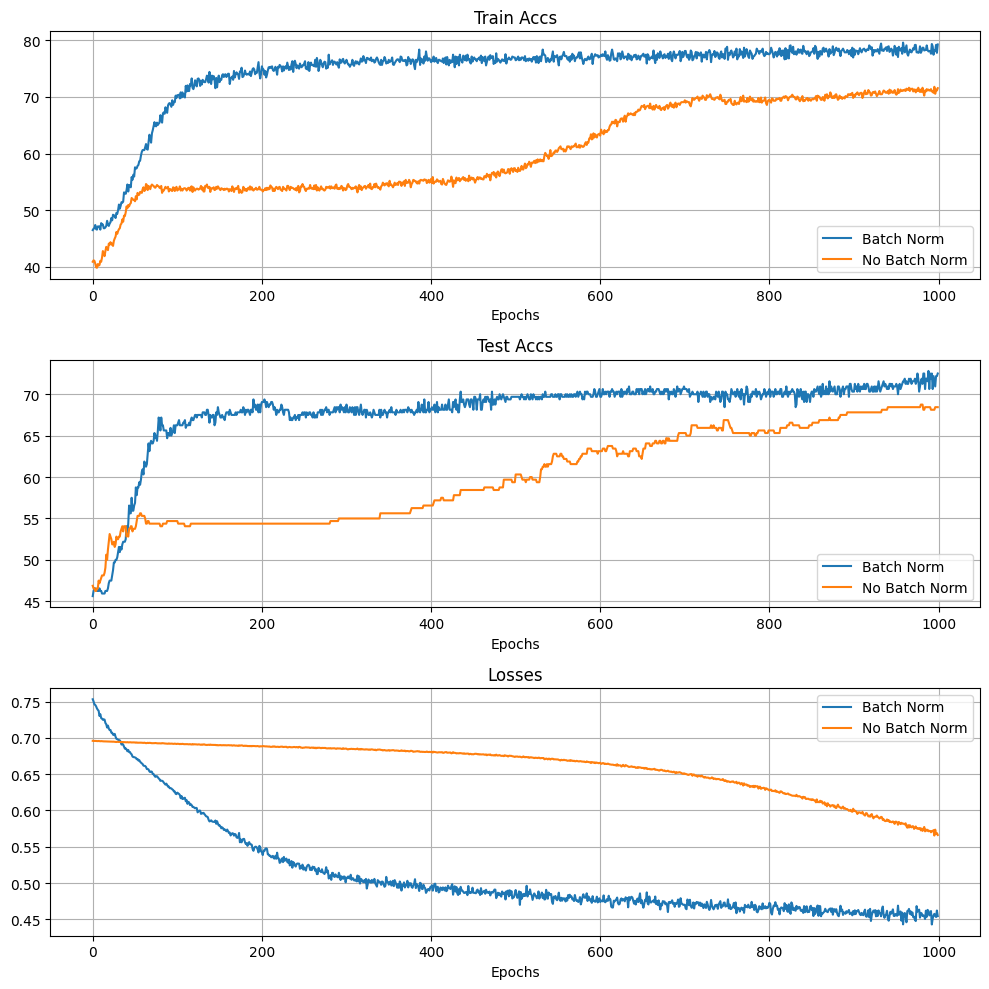

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].plot(bn_train_accs, '-', label = 'Batch Norm')
ax[0].plot(nbn_train_accs, '-', label = 'No Batch Norm')
ax[0].set_title('Train Accs')

ax[1].plot(bn_test_accs, '-', label = 'Batch Norm')
ax[1].plot(nbn_test_accs, '-', label = 'No Batch Norm')
ax[1].set_title('Test Accs')

ax[2].plot(bn_losses.detach(), '-', label = 'Batch Norm')
ax[2].plot(nbn_losses.detach(), '-', label = 'No Batch Norm')
ax[2].set_title('Losses')

for i in range(3):
  ax[i].legend()
  ax[i].grid()
  ax[i].set_xlabel('Epochs')

plt.tight_layout()
plt.show()

## Experiment 2

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### Data

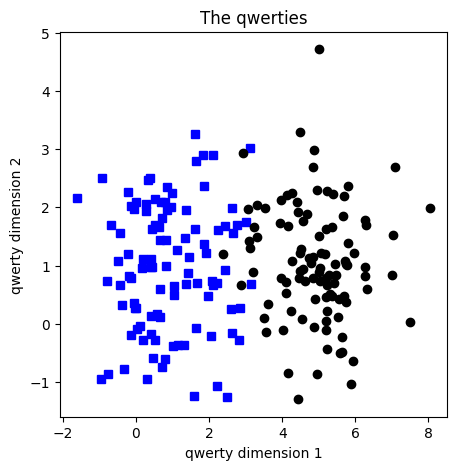

In [23]:
nPerClust = 100
blur = 1

# we pick 2 centroids of our random clusters
A = [1,1]
B = [5,1]

# We generate 100 random points around each centroid for it's x and y
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

# true labels, so just 0's and 1's in a single array
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust,1))))

# concatenate into a matrix, so x's of a hstacked with x's of b, same for y's. Then we transpose obtaining 2 kolumns 1 for x's 2 nd for y's
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

### Model

In [25]:
def ModelNoBatchNorm(learningRate):
  # build the model
  ANNclassify = nn.Sequential(
      nn.Linear(2,16),
      nn.ReLU(),
      nn.Linear(16,8),
      nn.ReLU(),
      nn.Linear(8,1),
      nn.Sigmoid()
  )

  learning_rate = .001

  # loss fn
  lossfun = nn.BCELoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNclassify.parameters(), lr = learning_rate)

  return ANNclassify, lossfun, optimizer

In [27]:
def ModelBatchNorm(learningRate):
  # build the model
  ANNclassify = nn.Sequential(
      nn.Linear(2,16),
      nn.ReLU(),
      nn.BatchNorm1d(16),
      nn.Linear(16,8),
      nn.ReLU(),
      nn.BatchNorm1d(8),
      nn.Linear(8,1),
      nn.Sigmoid()
  )

  learning_rate = .001

  # loss fn
  lossfun = nn.BCELoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNclassify.parameters(), lr = learning_rate)

  return ANNclassify, lossfun, optimizer

### Train

In [35]:
def trainModel(Model, lossfun, optimizer, num_epochs):

  epochs = num_epochs
  losses = np.zeros(epochs)

  for epoch in range(epochs):
    # forward
    yhat = Model(data)

    # losses
    loss = lossfun(yhat, labels)
    losses[epoch] = loss

    # log
    if epoch%10 == 0:
      print(f'Epoch {epoch}, Loss {loss}')

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final pred
  predictions = Model(data)
  predlabels = predictions > .5
  misclassified = np.where(predlabels != labels)[0]
  accuracy = 100 - 100*len(misclassified)/(2*nPerClust)

  return losses, predictions, accuracy, misclassified

### Single Run

In [36]:
ANNclassify_nbn, lossfun_nbn, optimizer_nbn = ModelNoBatchNorm(0.01)
losses_nbn, predictions_nbn, accuracy_nbn, misclassified_nbn = trainModel(ANNclassify_nbn, lossfun_nbn, optimizer_nbn, num_epochs = 1000)

Epoch 0, Loss 0.6762673258781433
Epoch 10, Loss 0.674975574016571
Epoch 20, Loss 0.6736800670623779
Epoch 30, Loss 0.6723799109458923
Epoch 40, Loss 0.6710730195045471
Epoch 50, Loss 0.6697604656219482
Epoch 60, Loss 0.6684422492980957
Epoch 70, Loss 0.6671189665794373
Epoch 80, Loss 0.6657910346984863
Epoch 90, Loss 0.6644576191902161
Epoch 100, Loss 0.6631186008453369
Epoch 110, Loss 0.6617724895477295
Epoch 120, Loss 0.6604191660881042
Epoch 130, Loss 0.6590602397918701
Epoch 140, Loss 0.6576947569847107
Epoch 150, Loss 0.6563218832015991
Epoch 160, Loss 0.6549426913261414
Epoch 170, Loss 0.6535589694976807
Epoch 180, Loss 0.6521696448326111
Epoch 190, Loss 0.6507736444473267
Epoch 200, Loss 0.6493719220161438
Epoch 210, Loss 0.6479639410972595
Epoch 220, Loss 0.6465497612953186
Epoch 230, Loss 0.6451291441917419
Epoch 240, Loss 0.6437009572982788
Epoch 250, Loss 0.6422662138938904
Epoch 260, Loss 0.6408242583274841
Epoch 270, Loss 0.6393760442733765
Epoch 280, Loss 0.63792157173156

In [37]:
ANNclassify_bn, lossfun_bn, optimizer_bn = ModelBatchNorm(0.01)
losses_bn, predictions_bn, accuracy_bn, misclassified_bn = trainModel(ANNclassify_bn, lossfun_bn, optimizer_bn, num_epochs = 1000)

Epoch 0, Loss 0.6650949716567993
Epoch 10, Loss 0.6372843384742737
Epoch 20, Loss 0.6128437519073486
Epoch 30, Loss 0.5900056958198547
Epoch 40, Loss 0.5677874088287354
Epoch 50, Loss 0.5449531078338623
Epoch 60, Loss 0.5223442316055298
Epoch 70, Loss 0.5015154480934143
Epoch 80, Loss 0.48284777998924255
Epoch 90, Loss 0.4673313498497009
Epoch 100, Loss 0.45418837666511536
Epoch 110, Loss 0.44323498010635376
Epoch 120, Loss 0.4337426722049713
Epoch 130, Loss 0.42517420649528503
Epoch 140, Loss 0.41744980216026306
Epoch 150, Loss 0.4103594720363617
Epoch 160, Loss 0.40352511405944824
Epoch 170, Loss 0.39707574248313904
Epoch 180, Loss 0.3910846412181854
Epoch 190, Loss 0.3853854238986969
Epoch 200, Loss 0.3799571096897125
Epoch 210, Loss 0.37473607063293457
Epoch 220, Loss 0.3697560131549835
Epoch 230, Loss 0.36495864391326904
Epoch 240, Loss 0.36027631163597107
Epoch 250, Loss 0.35576629638671875
Epoch 260, Loss 0.3514407277107239
Epoch 270, Loss 0.34717124700546265
Epoch 280, Loss 0.3

### Loss

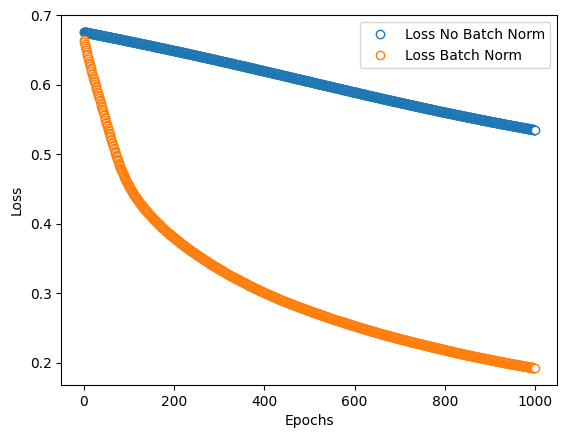

In [38]:
plt.plot(losses_nbn, 'o', markerfacecolor='w', linewidth=0.1)
plt.plot(losses_bn, 'o', markerfacecolor='w', linewidth=0.1)
plt.legend(['Loss No Batch Norm', 'Loss Batch Norm'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Learning Rates Experiment

In [42]:
numepochs = 500

# the set of learning rates to test
learningRates = np.linspace(0.001, .1, 40)

# initialize results output
accByLR_nbn = []
accByLR_bn = []
allLosses_nbn = np.zeros((len(learningRates), numepochs))
allLosses_bn = np.zeros((len(learningRates), numepochs))

# loop through learning rates
for i, lr in enumerate(learningRates):
  ANNclassify_nbn, lossfun_nbn, optimizer_nbn = ModelNoBatchNorm(lr)
  losses_nbn, predictions_nbn, totalacc_nbn, _ = trainModel(ANNclassify_nbn, lossfun_nbn, optimizer_nbn, num_epochs)
  # store the results
  accByLR_nbn.append(totalacc_nbn)
  allLosses_nbn[i, :] = losses_nbn

for i, lr in enumerate(learningRates):
  ANNclassify_bn, lossfun_bn, optimizer_bn = ModelBatchNorm(lr)
  losses_bn, predictions_bn, totalacc_bn, _ = trainModel(ANNclassify_bn, lossfun_bn, optimizer_bn, num_epochs)
  # store the results
  accByLR_bn.append(totalacc_bn)
  allLosses_bn[i, :] = losses_bn

Epoch 0, Loss 0.8567503094673157
Epoch 10, Loss 0.8492056131362915
Epoch 20, Loss 0.8420567512512207
Epoch 30, Loss 0.8352867364883423
Epoch 40, Loss 0.8288384079933167
Epoch 50, Loss 0.8227121829986572
Epoch 60, Loss 0.8169081807136536
Epoch 70, Loss 0.8114060759544373
Epoch 80, Loss 0.8061450719833374
Epoch 90, Loss 0.801129162311554
Epoch 100, Loss 0.7963457703590393
Epoch 110, Loss 0.7917466759681702
Epoch 120, Loss 0.7873333096504211
Epoch 130, Loss 0.7830859422683716
Epoch 140, Loss 0.7789949774742126
Epoch 150, Loss 0.775052547454834
Epoch 160, Loss 0.7712639570236206
Epoch 170, Loss 0.7676013708114624
Epoch 180, Loss 0.7640555500984192
Epoch 190, Loss 0.7606151103973389
Epoch 200, Loss 0.7572828531265259
Epoch 210, Loss 0.7540531754493713
Epoch 220, Loss 0.7509198188781738
Epoch 230, Loss 0.7478736639022827
Epoch 240, Loss 0.7449082732200623
Epoch 250, Loss 0.7420362830162048
Epoch 260, Loss 0.7392441034317017
Epoch 270, Loss 0.7365294098854065
Epoch 280, Loss 0.733899593353271

### Plots

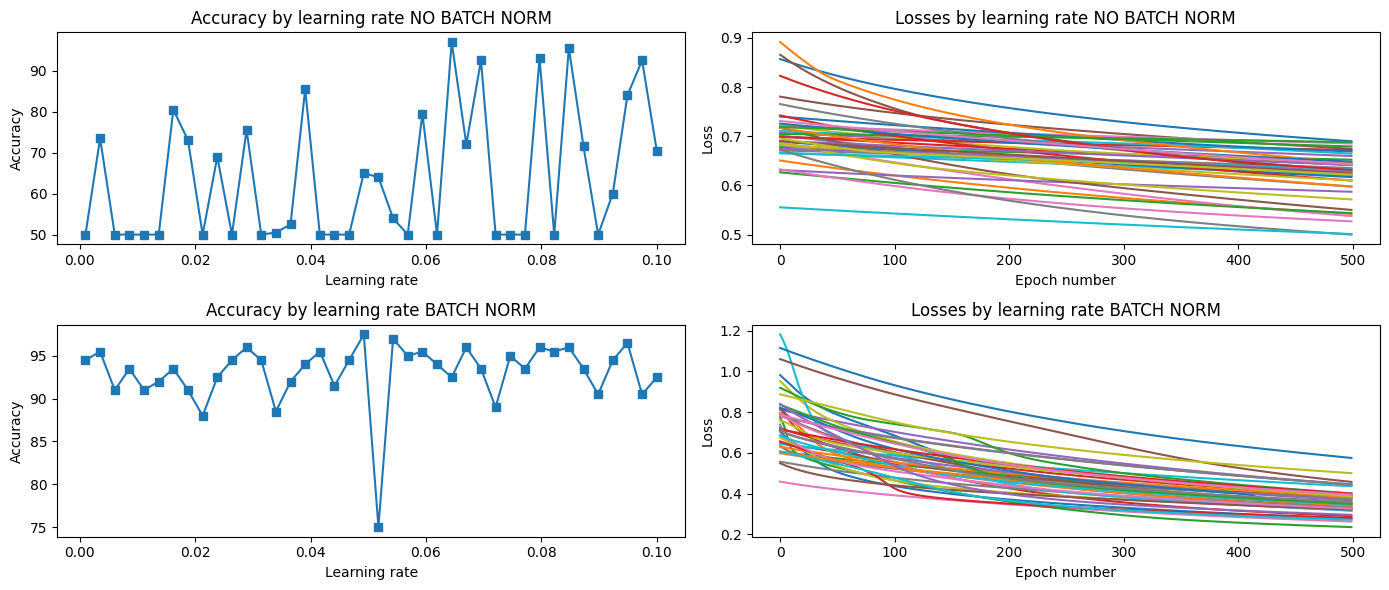

In [43]:
fig, ax = plt.subplots(2,2, figsize=(14,6))

ax[0][0].plot(learningRates, accByLR_nbn, 's-')
ax[0][0].set_xlabel('Learning rate')
ax[0][0].set_ylabel('Accuracy')
ax[0][0].set_title('Accuracy by learning rate NO BATCH NORM')

ax[0][1].plot(allLosses_nbn.T)
ax[0][1].set_title('Losses by learning rate NO BATCH NORM')
ax[0][1].set_xlabel('Epoch number')
ax[0][1].set_ylabel('Loss')



ax[1][0].plot(learningRates, accByLR_bn, 's-')
ax[1][0].set_xlabel('Learning rate')
ax[1][0].set_ylabel('Accuracy')
ax[1][0].set_title('Accuracy by learning rate BATCH NORM')

ax[1][1].plot(allLosses_bn.T)
ax[1][1].set_title('Losses by learning rate BATCH NORM')
ax[1][1].set_xlabel('Epoch number')
ax[1][1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

As we can see thanks to the batch norm we were able to get rid of non-learning runs. Some of the learning rates previously under-performed when run without Batch Norm. After Batch Norm addition before linear layer, we got much better results. Every learning rate, performs above 80% of final accuracy, while before Batch Norm around half of the learning rates didn't reach 50% of total accuracy.